In [1]:
%load_ext autoreload
%autoreload 2
from pathlib import Path
import torch
from pydantic import (
    BaseModel,
    Field,
    annotated_types,
    parse_obj_as,
    validator,
    root_validator,
)
from typing import Annotated
import torchvision
import json
import torch.nn as nn
from torchvision.models.detection.faster_rcnn import (
    FastRCNNPredictor,
    fasterrcnn_resnet50_fpn,
)
from courtvision.data import CourtVisionDataset
from courtvision.data import collate_fn
from torchvision import datapoints

DATASET_ANNOTATIONS_DIR = Path(
    "/Users/benjamindecharmoy/projects/courtvision/datasets/annotations/"
)
DATASET_DATA_DIR = Path("/Users/benjamindecharmoy/projects/courtvision/data/frames")
MODEL_DIR = Path("/Users/benjamindecharmoy/projects/courtvision/models")
MODEL_DIR_BALL_DETECTOR = MODEL_DIR / "ball_detector"

# dinov2_vits14 = torch.hub.load("facebookresearch/dinov2", "dinov2_vits14")

In [2]:
from courtvision.data import PadelDataset
from courtvision.swiss import get_latest_file

dataset_filename = get_latest_file(dir=DATASET_ANNOTATIONS_DIR, file_suffix=".json")
dataset_name = dataset_filename.stem
with open(
    dataset_filename,
    "r",
) as fp:
    padel_dataset = PadelDataset(samples=json.load(fp))

In [3]:
courtvision_dataset = CourtVisionDataset(dataset=padel_dataset, root=DATASET_DATA_DIR)
print(f"{len(courtvision_dataset)=}")

len(courtvision_dataset)=130


In [4]:
sample, image = courtvision_dataset[2]
CourtVisionDataset.show_sample(annotation=sample.annotations, image=image)
len(courtvision_dataset)

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:1                                                                                    │
│                                                                                                  │
│ ❱ 1 sample, image = courtvision_dataset[2]                                                       │
│   2 CourtVisionDataset.show_sample(annotation=sample.annotations, image=image)                   │
│   3 len(courtvision_dataset)                                                                     │
│   4                                                                                              │
│                                                                                                  │
│ /Users/benjamindecharmoy/projects/courtvision/courtvision/data.py:173 in __getitem__             │
│                                                                                                  │
│   170 │                                                                                          │
│   171 │   def __getitem__(self, idx) -> tuple[CourtAnnotatedSample, torch.Tensor]:               │
│   172 │   │   sample = self.dataset.samples[idx]                                                 │
│ ❱ 173 │   │   image = load_timg(CourtVisionDataset.find_image_path(self.root, sample=sample))    │
│   174 │   │   return (                                                                           │
│   175 │   │   │   sample,                                                                        │
│   176 │   │   │   image,                                                                         │
│                                                                                                  │
│ /Users/benjamindecharmoy/projects/courtvision/courtvision/vis.py:139 in load_timg                │
│                                                                                                  │
│   136                                                                                            │
│   137 def load_timg(file_name):                                                                  │
│   138 │   """Loads the image with OpenCV and converts to torch.Tensor."""                        │
│ ❱ 139 │   img = load_image(file_name)                                                            │
│   140 │   # convert image to torch tensor                                                        │
│   141 │   return K.image_to_tensor(img, None).float() / 255.0                                    │
│   142                                                                                            │
│                                                                                                  │
│ /Users/benjamindecharmoy/projects/courtvision/courtvision/vis.py:146 in load_image               │
│                                                                                                  │
│   143                                                                                            │
│   144 def load_image(file_name):                                                                 │
│   145 │   """Loads the image with OpenCV."""                                                     │
│ ❱ 146 │   assert os.path.isfile(file_name), f"Invalid file {file_name}"  # nosec                 │
│   147 │   # load image with OpenCV                                                               │
│   148 │   if isinstance(file_name, Path):                                                        │
│   149 │   │   file_name = file_name.as_posix()                                                   │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
AssertionError: Invalid file 
/Users/benjamindecharmoy/projects/courtvision/data/frames/upload/1/cbeffe0e-curated_001_frame_0003.png

In [5]:
from courtvision.models import get_fasterrcnn_ball_detection_model

model_path = get_latest_file(
    dir=Path(MODEL_DIR_BALL_DETECTOR),
)
model_name = f"fasterrcnn_resnet50_fpn_{dataset_name}"
model = get_fasterrcnn_ball_detection_model(model_path=model_path)
model

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       

In [6]:
courtvision_dataloader = torch.utils.data.DataLoader(
    courtvision_dataset,
    batch_size=4,
    shuffle=True,
    num_workers=0,
    collate_fn=collate_fn,
)

In [7]:
from courtvision.data import validate_dataloader

validate_dataloader(dataloader=courtvision_dataloader)

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:3                                                                                    │
│                                                                                                  │
│   1 from courtvision.data import validate_dataloader                                             │
│   2                                                                                              │
│ ❱ 3 validate_dataloader(dataloader=courtvision_dataloader)                                       │
│   4                                                                                              │
│                                                                                                  │
│ /Users/benjamindecharmoy/projects/courtvision/courtvision/data.py:312 in validate_dataloader     │
│                                                                                                  │
│   309                                                                                            │
│   310                                                                                            │
│   311 def validate_dataloader(dataloader: DataLoader):                                           │
│ ❱ 312 │   for (targets, images) in dataloader:                                                   │
│   313 │   │   assert all(o["boxes"].shape for o in targets)                                      │
│   314 │   │   assert all(o.shape for o in images)                                                │
│   315                                                                                            │
│                                                                                                  │
│ /Users/benjamindecharmoy/projects/courtvision/.venv/lib/python3.11/site-packages/torch/utils/dat │
│ a/dataloader.py:634 in __next__                                                                  │
│                                                                                                  │
│    631 │   │   │   if self._sampler_iter is None:                                                │
│    632 │   │   │   │   # TODO(https://github.com/pytorch/pytorch/issues/76750)                   │
│    633 │   │   │   │   self._reset()  # type: ignore[call-arg]                                   │
│ ❱  634 │   │   │   data = self._next_data()                                                      │
│    635 │   │   │   self._num_yielded += 1                                                        │
│    636 │   │   │   if self._dataset_kind == _DatasetKind.Iterable and \                          │
│    637 │   │   │   │   │   self._IterableDataset_len_called is not None and \                    │
│                                                                                                  │
│ /Users/benjamindecharmoy/projects/courtvision/.venv/lib/python3.11/site-packages/torch/utils/dat │
│ a/dataloader.py:678 in _next_data                                                                │
│                                                                                                  │
│    675 │                                                                                         │
│    676 │   def _next_data(self):                                                                 │
│    677 │   │   index = self._next_index()  # may raise StopIteration                             │
│ ❱  678 │   │   data = self._dataset_fetcher.fetch(index)  # may raise StopIteration              │
│    679 │   │   if self._pin_memory:                                                              │
│    680 │   │   │   data = _utils.pin_memory.pin_memory(data, self._pin_memory_device)            │
│    681 │   │   return data                                                                       │
│                                                            

In [12]:
def train_one_epoch(
    model, optimizer, data_loader, device, epoch, print_freq, scaler=None
):
    model.train()
    # metric_logger = utils.MetricLogger(delimiter="  ")
    # metric_logger.add_meter("lr", utils.SmoothedValue(window_size=1, fmt="{value:.6f}"))
    header = f"Epoch: [{epoch}]"

    lr_scheduler = None
    if epoch == 0:
        warmup_factor = 1.0 / 1000
        warmup_iters = min(1000, len(data_loader) - 1)

        lr_scheduler = torch.optim.lr_scheduler.LinearLR(
            optimizer, start_factor=warmup_factor, total_iters=warmup_iters
        )

    for (
        targets,
        images,
    ) in data_loader:  # metric_logger.log_every(data_loader, print_freq, header):
        # images = list(image.to(device) for image in images)
        # targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        # print(targets.shape)
        # print(targets)
        with torch.cuda.amp.autocast(enabled=scaler is not None):
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
            # print(losses)

        print(loss_dict)
        # reduce losses over all GPUs for logging purposes
        # loss_dict_reduced = utils.reduce_dict(loss_dict)
        losses_reduced = sum(loss for loss in loss_dict.values())

        loss_value = losses_reduced.item()
        import math

        if not math.isfinite(loss_value):
            print(f"Loss is {loss_value}, stopping training")
            print(loss_dict)
            import sys

            sys.exit(1)

        optimizer.zero_grad()
        if scaler is not None:
            scaler.scale(losses).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            losses.backward()
            optimizer.step()

        if lr_scheduler is not None:
            lr_scheduler.step()

        # metric_logger.update(loss=losses_reduced, **loss_dict_reduced)
        # metric_logger.update(lr=optimizer.param_groups[0]["lr"])

    # return metric_logger

In [13]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

# let's train it for 10 epochs
num_epochs = 100
device = "cpu"
for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    print(f"Epoch {epoch} of {num_epochs}")
    train_one_epoch(
        model, optimizer, courtvision_dataloader, device, epoch, print_freq=10
    )
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    # evaluate(model, data_loader_test, device=device)
    torch.save(
        model.state_dict(),
        MODEL_DIR_BALL_DETECTOR / f"{model_name}-{epoch}.pt",
    )

Epoch 0 of 100
{'loss_classifier': tensor(0.0116, grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.0360, grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0013, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0358, grad_fn=<DivBackward0>)}
{'loss_classifier': tensor(0.0079, grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.0241, grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0034, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0270, grad_fn=<DivBackward0>)}
{'loss_classifier': tensor(0.0066, grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.0321, grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0018, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0291, grad_fn=<DivBackward0>)}
{'loss_classifier': tensor(0.0208, grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.0407, grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0052, grad_fn=<BinaryCrossEntropyWithLogitsBa

KeyboardInterrupt: 

In [13]:
with torch.no_grad():
    # fast_model.backbone.body = nn.Sequential(*[patch_embed, *mod_list[:]])
    # fast_model.roi_heads.box_predictor = head
    model.eval()
    out = model(image)

In [1]:
torch.save(
    model.state_dict(),
    MODEL_DIR_BALL_DETECTOR / "{model_name}.pt",
)

NameError: name 'torch' is not defined

/var/folders/nv/c7kqzw0j08q0bg0fjbmbbr4w0000gn/T/ipykernel_13941/2872721484.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(image.squeeze(0) * 255.0, dtype=torch.uint8), out[0]["boxes"], width=3


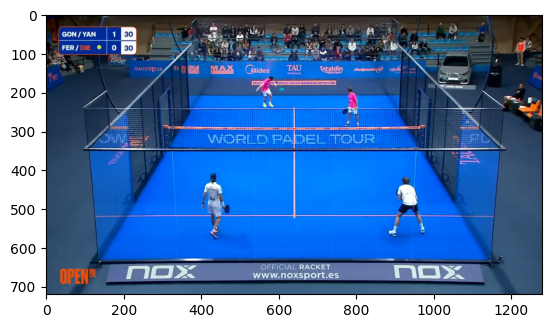

In [15]:
from torchvision.utils import draw_bounding_boxes

image_dd = draw_bounding_boxes(
    torch.tensor(image.squeeze(0) * 255.0, dtype=torch.uint8), out[0]["boxes"], width=3
)
from matplotlib import pyplot as plt

plt.imshow(image_dd.permute(1, 2, 0))

[{'boxes': tensor([[132.7517,  79.5820, 144.2173,  89.1404],
        [133.5488,  82.3853, 144.2331,  92.9684],
        [130.2062,  81.4318, 141.5005,  89.9317]]), 'labels': tensor([1, 1, 1]), 'scores': tensor([0.1531, 0.1081, 0.0696])}]


/var/folders/nv/c7kqzw0j08q0bg0fjbmbbr4w0000gn/T/ipykernel_54775/859595141.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(images[0].squeeze(0) * 255.0, dtype=torch.uint8),


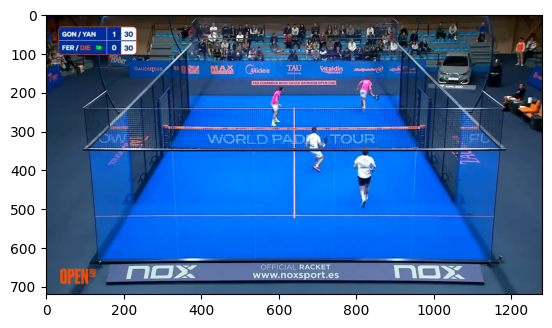

In [101]:
import os
from pathlib import Path
import random
from PIL import Image


class CourtvisionImageOnlyDataset(torch.utils.data.Dataset):
    def __init__(self, root):
        # self.dataset = dataset
        self.root = root
        self.dataset = sorted(Path(root).glob("*.png"))

    def __getitem__(self, idx):
        # sample = self.dataset[idx]
        idx = random.randint(0, len(self.dataset) - 1)
        image = Image.open(self.dataset[idx]).convert("RGB")
        image = torchvision.transforms.ToTensor()(image)
        return image

    def __len__(self):
        return len(self.dataset)


full_set = CourtvisionImageOnlyDataset(
    root="/Users/benjamindecharmoy/projects/courtvision/data/frames/curated_001"
)
for images in torch.utils.data.DataLoader(full_set, batch_size=1, shuffle=True):
    with torch.no_grad():
        model.eval()
        out = model(images)
        print(out)
    image_dd = draw_bounding_boxes(
        torch.tensor(images[0].squeeze(0) * 255.0, dtype=torch.uint8),
        out[0]["boxes"],
        width=3,
    )
    from matplotlib import pyplot as plt

    plt.imshow(image_dd.permute(1, 2, 0))
    plt.show()
    break

In [ ]:
rr.log_image("frame/test/img", image.squeeze(0).permute(1, 2, 0))
# out[0]["boxes"]

In [ ]:
dd = [box.tolist() for box in out[0]["boxes"]]
rr.log_rects("frame/boxes", dd, rect_format=RectFormat.XYXY)

In [ ]:
from rerun.components.rect2d import RectFormat

rr.log_rect("frame/box", out[0]["boxes"][2].tolist(), rect_format=RectFormat.XYXY)

In [ ]:
out[0]["boxes"][0].tolist()

[586.6439819335938, 360.8269348144531, 1062.5076904296875, 670.1864624023438]

In [ ]:
image.shape

torch.Size([1, 3, 720, 1280])

In [ ]:
out[0]

{'boxes': tensor([[ 586.6440,  360.8269, 1062.5077,  670.1865],
         [ 597.6040,  191.3133,  617.9384,  211.2779],
         [ 297.4283,  581.7656, 1115.0757,  708.7494],
         [ 389.4426,  128.8055,  970.5952,  490.9042],
         [ 434.5761,  284.2084,  946.3016,  621.3353],
         [ 761.4454,  195.3744,  802.9850,  293.6284],
         [ 428.8613,  451.5882,  473.8964,  573.3542],
         [ 821.0404,  284.2837, 1154.2217,  720.0000],
         [ 898.5524,  426.9127,  946.2028,  537.3666],
         [ 416.9436,  498.2014, 1103.0070,  664.2693],
         [ 878.7841,  415.2511,  968.8537,  574.6574],
         [ 757.9148,   17.3750,  977.1315,  369.8183],
         [ 763.1102,  232.0803,  817.0454,  287.9791],
         [ 573.9623,  174.1141,  595.5928,  222.5417],
         [ 588.5248,  189.3533,  609.8690,  209.1296],
         [ 406.5399,   64.9292,  815.7542,  349.9398],
         [ 471.6840,   19.7566,  897.4198,  720.0000],
         [1229.1489,  222.3493, 1280.0000,  271.0620],
 

In [77]:
import rerun as rr
from rerun import RectFormat

rr.init("sss", spawn=True, strict=True)

[2023-05-23T14:22:11Z WARN  rerun::run] Failed to bind TCP address "0.0.0.0:9876". Another Rerun instance is probably running.


In [112]:
model_path = (
    "/Users/benjamindecharmoy/projects/courtvision/runs/detect/train2/weights/best.pt"
)
from ultralytics import YOLO

model = YOLO(model=model_path, task="detect")

In [113]:
dd = model.predict(
    "/Users/benjamindecharmoy/projects/courtvision/data/frames/curated_001/curated_001_frame_0013.png"
)


image 1/1 /Users/benjamindecharmoy/projects/courtvision/data/frames/curated_001/curated_001_frame_0013.png: 384x640 (no detections), 81.8ms
Speed: 0.6ms preprocess, 81.8ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 640)


In [105]:
# dd

In [106]:
import torch

image = torch.tensor(dd[0].orig_img)
len(image.shape)

shape = image.shape
non_empty_dims = [d for d in shape if d != 1]
len(non_empty_dims)
image.shape

torch.Size([720, 1280, 3])

In [107]:
rr.log_image("frame/image", image)
rr.log_rects("frame/ball", dd[0].boxes.xyxy.numpy(), rect_format=RectFormat.XYXY)

dd


In [13]:
from rerun import RectFormat

In [102]:
dd[0].boxes

WARNING ⚠️ 'Boxes.boxes' is deprecated. Use 'Boxes.data' instead.


ultralytics.yolo.engine.results.Boxes object with attributes:

boxes: tensor([], size=(0, 6))
cls: tensor([])
conf: tensor([])
data: tensor([], size=(0, 6))
id: None
is_track: False
orig_shape: tensor([ 720, 1280])
shape: torch.Size([0, 6])
xywh: tensor([], size=(0, 4))
xywhn: tensor([], size=(0, 4))
xyxy: tensor([], size=(0, 4))
xyxyn: tensor([], size=(0, 4))

In [82]:
dd[0].boxes

WARNING ⚠️ 'Boxes.boxes' is deprecated. Use 'Boxes.data' instead.


ultralytics.yolo.engine.results.Boxes object with attributes:

boxes: tensor([[1.4664e+02, 3.4641e+02, 1.0859e+03, 6.3812e+02, 3.3012e-01, 0.0000e+00]])
cls: tensor([0.])
conf: tensor([0.3301])
data: tensor([[1.4664e+02, 3.4641e+02, 1.0859e+03, 6.3812e+02, 3.3012e-01, 0.0000e+00]])
id: None
is_track: False
orig_shape: tensor([ 720, 1280])
shape: torch.Size([1, 6])
xywh: tensor([[616.2769, 492.2622, 939.2793, 291.7102]])
xywhn: tensor([[0.4815, 0.6837, 0.7338, 0.4052]])
xyxy: tensor([[ 146.6372,  346.4071, 1085.9165,  638.1173]])
xyxyn: tensor([[0.1146, 0.4811, 0.8484, 0.8863]])